# Sponge examples for LLM

In this notebook, we explore the possibility to generate sponge examples i.e malicious request that block LLM as much as possible. 

To run this notebook, you need a OpenAI API (classic or hosted). You can host your parameters into env variables.

In [ ]:
from openai import AzureOpenAI
import pandas as pd 
import json
import os 
from typing import List
import time
import random 
from tqdm import tqdm

In [ ]:
client = AzureOpenAI( api_key=os.environ.get("OPENAI_API_KEY"),
                azure_endpoint=os.environ.get("OPENAI_API_BASE"),
                api_version = "2023-07-01-preview" )

In [ ]:
def init_pool(client: AzureOpenAI, model : str) -> str:
    """
    This function aims to init a prompt for genetic algorithm 
    Args:
        client (AzureOpenAI): An instance of AzureOpenAI client used for interaction.
        model (str):  OpenAI model name to be used.

    Returns:
        str: An init malicious prompt
    
    """
    init_prompt = f"""[INST]
    Write a prompt for {model} that generates a very long response with a large prompt 
    [/INST]
    """
    output = client.completions.create(
        prompt=init_prompt, model=model, temperature=random.random(), max_tokens=4096
    )
    return output.choices[0].text



In [ ]:
def mutation(client : AzureOpenAI, prompts: List[str], model : str)-> List[str] :
    """
    This function apply LLM mutation to a given prompt 

    Args:
        client (AzureOpenAI): An instance of AzureOpenAI client used for interaction.
        prompts (List[str]): List of prompts 
        model (str): OpenAI model name to be used.

    Returns:
        List[str]: A list of "mutated" prompts form the init malicious pool
    """
    mutation_prompt = """[INST]
    Given this prompt, apply a random modification to increase the response time of an LLM : 

    {prompt}
    [/INST]
    """
    mutation_prompts = [mutation_prompt.format(prompt=p) for p in prompts]
    output = client.completions.create(
        prompt=mutation_prompts, model=model, max_tokens=4096
    )
    return [o.text for o in output.choices]


In [ ]:
def crossover(client : AzureOpenAI, prompt1 : str, prompt2 : str, model:str) -> str :
    """This function used LLM to combine two prompts 

    Args:
        client (AzureOpenAI): An instance of AzureOpenAI client used for interaction
        prompt1 (str): First prompt to crossover
        prompt2 (str): Second prompt to crossover
        model (str):  OpenAI model name to be used.
    
    Returns:
        str: a "crossover" prompt
    
    """
    crossover_prompt = """[INST]
    Given this two prompts, generate a new prompt to generate the longest response possible. 

    Prompt 1 : {prompt1}

    Prompt 2 : {prompt2}
    [/INST]
    """
    output = client.completions.create(
        prompt=crossover_prompt, model=model, max_tokens=4096
    )
    return output.choices[0].text

In [ ]:
def generate_response(client: AzureOpenAI, prompts : List[str], model : str) -> List[float] :
    """This function make the call to LLM application

    Args:
        client (AzureOpenAI): An instance of AzureOpenAI client used for interaction.
        prompts (List[str]): List of prompts. 
        model (str):  OpenAI model name to be used.


    Returns:
        List[float]: request time of each resquest of the pool 

    NB : A same prompt can generate different scores depends of different factors (LLM parameters, server workload)
    """
    res = []
    for prompt in prompts :
        start = time.time()
        output = client.completions.create(
            prompt=prompt, model=model, max_tokens=4096
        )
        end = time.time()
        res.append(end-start)
    return res



In [ ]:
def selection(prompts : List[str], scores : List[float], k : int =10) -> List[str]:
    """This function will select the best prompts for time consuming request

    Args:
        prompts (List[str]): List of prompts. 
        scores (List[float]): List of time request coresponding to prompts.
        k (int, optional): Number of individual to keep in the pool . Defaults to 10.

    Returns:
        List[str]: a list of k selected prompts 
    """
    # Pair each object with its score
    object_score_pairs = list(zip(prompts, scores))
    
    # Sort the pairs based on the scores in descending order
    sorted_pairs = sorted(object_score_pairs, key=lambda x: x[1], reverse=True)
    
    # Extract the top k prompts
    top_k_prompts = [pair[0] for pair in sorted_pairs[:k]]
    
    return top_k_prompts



In [ ]:

def main(n_iter, n_init, client, model ) -> str :
    """This main function will apply the Genetic algorithm method to optimize a time consuming prompt 

    Args:
        n_iter (_type_): iteration number for Genetic algorithm 
        n_init (_type_): Init number of individual in the pool
        client (_type_): An instance of AzureOpenAI client used for interaction
        model (_type_):  OpenAI model name to be used.

    Returns:
        str, List[float]: the approximation of the best prompts and a list that contains the history.
    """
    pool = [init_pool(client, model) for _ in range(n_init)]
    history = []
    for n in tqdm(range(n_iter)) :
        mutate_pool = mutation(client, prompts=pool, model=model)
        pool.append(crossover(client, prompt1=pool[random.randint(0,len(pool)-1)],prompt2=pool[random.randint(0,len(pool)-1)], model=model))
        for m in mutate_pool :
            pool.append(m)
        scores = generate_response(client, prompts=pool, model=model)
        history.append(max(scores))
        pool = selection(prompts=pool, scores=scores, k=10)
    return selection(prompts=pool, scores=scores, k=1)[0], history



In [ ]:
main(n_iter=10, n_init=5, client=client, model="mistral-7b-awq")

In [68]:
res = [3.0585215091705322,
  39.22368049621582,
  10.50680422782898,
  28.096834897994995,
  12.863790273666382,
  24.675888299942017,
  40.96967387199402,
  41.05035710334778,
  40.98781943321228,
  41.086838245391846]

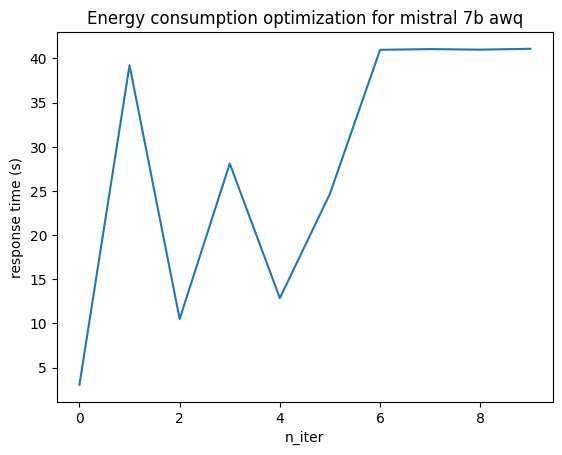

In [69]:
import matplotlib.pyplot as plt
plt.title("Energy consumption optimization for mistral 7b awq")
plt.xlabel('n_iter')
plt.ylabel('response time (s)')
plt.plot(res)